In [46]:
import pandas as pd
import numpy as np
import deepchem as dc
import matplotlib.pyplot as plt
from itertools import combinations

In [6]:
admet_train = pd.read_csv('../admet/data/train_admet_all.csv')
admet_test = pd.read_csv('../admet/data/test_admet_all.csv')

In [9]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

We shall split up the training set into train/val.  The 'test' set here is those to be submitted to the competition 

In [13]:
fpgen = AllChem.GetRDKitFPGenerator()


train_fps = [
            fpgen.GetFingerprint(Chem.MolFromSmiles(x)) for x in  admet_train.CXSMILES.values
        ]
test_fps = [
            fpgen.GetFingerprint(Chem.MolFromSmiles(x)) for x in admet_test.CXSMILES.values
        ] 

Training set will be the molecules furthest away from the test set.  The Validation set will be those closest to the test set. 

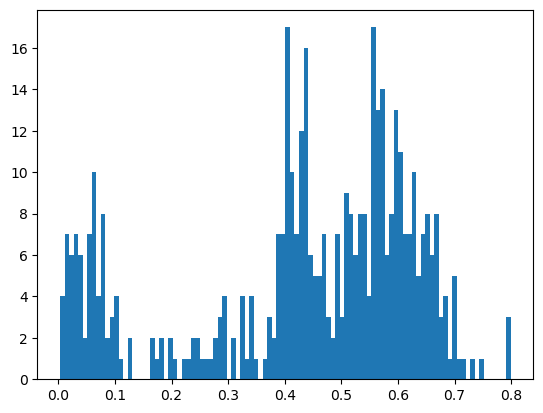

In [60]:
fps = train_fps + test_fps
train_frac = 0.8
val_frac = 1-train_frac

deployment_ix = [int(x) for x in np.arange(len(train_fps), len(fps))]
all_train_ix = list(range(len(train_fps)))
all_fps_ix = list(range(len(fps)))


assert (set(all_train_ix) | set(deployment_ix) == set(all_fps_ix))
assert len(set(all_train_ix) & set(deployment_ix)) == 0


def distance(i, j):
    return 1 - DataStructs.TanimotoSimilarity(fps[i], fps[j])


min_dist_to_test = []

for i in all_train_ix: 
    min_dist_to_test.append(min([distance(i, j) for j in deployment_ix]))


_ = plt.hist(min_dist_to_test, bins=100)

The validation set will the closest `val_frac` % to the  deployment set

In [62]:
val_dist_cutoff = np.quantile(min_dist_to_test, val_frac)
val_ix = np.where(min_dist_to_test < val_dist_cutoff)[0]
train_ix = np.where(min_dist_to_test >= val_dist_cutoff)[0]

In [67]:
assert (set(val_ix) | set(train_ix) == set(all_train_ix))
assert len(set(val_ix) & set(train_ix)) == 0
len(train_ix), len(val_ix), f"{len(train_ix)/len(all_train_ix):4.1%}"

(347, 87, '80.0%')

Text(0.5, 0, 'Tanimoto distance to deployment set')

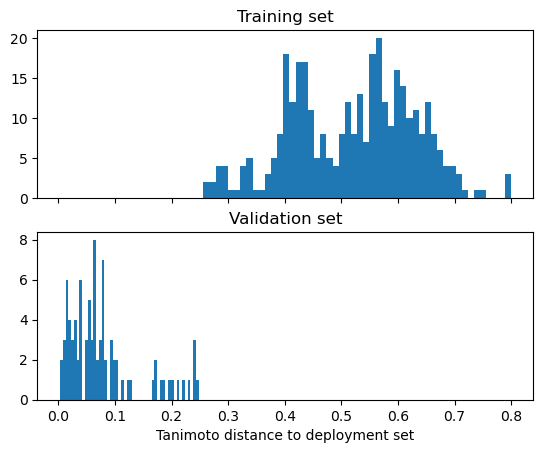

In [75]:
n_bins = 50
fig, axes = plt.subplots(2, sharex=True)
axes[0].hist([min_dist_to_test[i] for i in train_ix], bins=n_bins)
axes[0].set_title('Training set' )
axes[1].hist([min_dist_to_test[i] for i in val_ix], bins=n_bins)
axes[1].set_title('Validation set' )
axes[1].set_xlabel('Tanimoto distance to deployment set')

In [78]:
np.save( '../admet/data/val_split_idx.npy', val_ix)
np.save( '../admet/data/train_split_idx.npy', train_ix)